In [1]:
from sympy.solvers import solve
from sympy import Symbol
from scipy.integrate import odeint
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

# Question 1
### c) Compute and plot the graph of the equilibria

In [2]:
def get_default_params():
    #Default values from Table 1
    R0  =  2.0  #[mm/day]   default amount of rainfall 
    r_m =  0.3  #[1/yr]     maximal rate of tree cover expansion rate
    h_R =  0.5  #[mm/day]   rainfall value where r is reduced by half
    m_n =  0.15 #[1/yr]     maximal loss rate due to nursing effect
    h_n = 10    #[%]        tree cover below which rate of loss increases steeply (nursing effect)
    m_f =  0.11 #[1/yr]     maximal rate of loss due to fire mortality
    h_f = 60    #[%]        tree cover below which rate of loss increases steeply (fire mortality)
    p   =  7    #[]         Hill function exponent
    k   = 90    #[%]        Maximal carrying capacity
    b   =  2
    r_R =  1
    return R0, r_m, h_R, m_n, h_n, m_f, h_f, p, k,b,r_R

In [3]:
def find_roots(R, params):

    R0, r_m, h_R, m_n, h_n, m_f, h_f, p, k,b,r_R = params
    r = r_m * (R/(h_R + R))

    T = Symbol('T')
    sol = solve([T>=0,T<=100,
                T*( (r* (1 - (T/k)))
                +(-m_n*(h_n/(T + h_n)))   
                +(-m_f * (pow(h_f, p) / (pow(T, p) + pow(h_f, p)))))],T)
    
    sols = [float(sol.args[2].args[i].args[1]) for i in range(len(sol.args[2].args))]
    sols = [x for x in sols if x >= 0]
    sols = [x for x in sols if x<=100]
    return sols

100%|██████████| 100/100 [00:12<00:00,  7.78it/s]


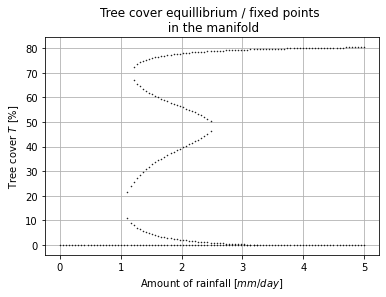

In [4]:
def Q1_plot():
    params = get_default_params()
    Rs = np.linspace(0,5,100)
    ys = []
    xs = []


    for R in tqdm(Rs):
        sols = find_roots(R,params)
        ys.extend(sols)
        xs.extend(R*np.ones(len(sols)))

    plt.plot(xs,ys,'.k',markersize=1)
    plt.ylabel(r'Tree cover $T$ $\left[\%\right]$')
    plt.xlabel(r'Amount of rainfall $\left[mm/day\right]$')
    plt.title("Tree cover equillibrium / fixed points \n in the manifold")
    plt.grid()
    plt.show()

    return
Q1_plot()

# Question 2
### Write code to simulate the two-dimensional equations for tree cover and rainfall dynamics.

In [5]:
def Extended_model(R0,T0,params):
    R_, r_m, h_R, m_n, h_n, m_f, h_f, p, k,b,r_R = params
    R_const = R0
    
    def f(y,t):
        T,R = y
        dydt = [T*( (r_m * (R/(h_R + R))* (1 - (T/k)))
                     +(-m_n*(h_n/(T + h_n)))   
                     +(-m_f * (pow(h_f, p) / (pow(T, p) + pow(h_f, p))))), 
                r_R*(b/k)*T-r_R*R+r_R*R_const]

        return dydt
    
    T   = np.linspace(0,600,1000)
    Y   = odeint(f, [T0,R0], T)

    return T,Y


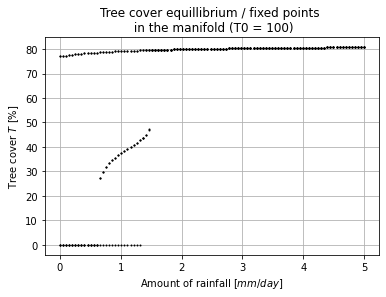

In [6]:
def Q2_plot():
    R0s = np.linspace(0,5,100)
    T0s = [5,25,50,75,100]
    n=5
    params = get_default_params()

    R_600 = []
    T_600 = []

    for T0 in T0s:
        for R0 in R0s:

            t,y = Extended_model(R0,T0,params)
            R_600.append(R0)
            T_600.append(y[-1,0])

    R_600 = np.reshape(R_600,(n,100))
    T_600 = np.reshape(T_600,(n,100))

    plt.figure()
    for i in range(len(R_600)):
        plt.plot(R_600[i,:],T_600[i,:],".k",markersize=2)

    plt.ylabel(r'Tree cover $T$ $\left[\%\right]$')
    plt.xlabel(r'Amount of rainfall $\left[mm/day\right]$')
    plt.title("Tree cover equillibrium / fixed points \n in the manifold (T0 = %d)" %T0s[i])
    plt.grid()
    plt.show()
Q2_plot()

# Question 4
### Model human action in terms of direct deforestation

In [7]:
def human_action_model(T,T0,params, a=5e-3, b=5e-3, c=5e-4, rate_def=0.01,rate_ref=0.001,mu=0.05):
    """
        Parameters
        ----------
        T       : Array of time step where the function will be evaluated

        T0      : Curent tree cover

        params  : Parameters of the model given in the statement (Table 1)

        a       : transition rate from Susceptible (S) to Recovered (R) group
        b       : transition rate from Susceptible (S) to Infected  (I) group
        c       : transition rate from Infected    (I) to Recovered (R) group 
        rate_def: rate of deforestation
        rate_ref: rate of reforestation
        mu      : death rate of the population

        Returns
        -------
        xks     : An array
                  representing xk for every iteration
        norms   : An array
                  representing ||xk-xf|| for every iteration

    """
    R0, r_m, h_R, m_n, h_n, m_f, h_f, p, k,b_,r_R = params

    def f(y,t):
        T,S,I,R = y
        dydt = [T*( (r_m * (R/(h_R + R))* (1 - (T/k)))
                     +(-m_n*(h_n/(T + h_n)))   
                     +(-m_f * (pow(h_f, p) / (pow(T, p) + pow(h_f, p)))))-rate_def*I*T+rate_ref*R*(100-T),

                mu*(S+I+R)    -a*S*(100-T) - b*S*T               - mu*S,
                                           + b*S*T - c*I*(100-T) - mu*I,
                              +a*S*(100-T)         + c*I*(100-T) - mu*R ]

        return dydt

    Y = odeint(f, [T0,100,0,0], T)
    
    return Y

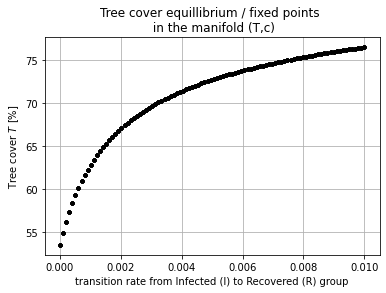

In [8]:
def Q4_plot1():
    params = get_default_params()

    ts=np.linspace(0,600,500)
    T0s = np.linspace(0,100,10)
    Cs   = np.linspace(0,1e-2,100)
    ys = []
    cs = []
    for T0 in T0s:
        for c in Cs:

            y = human_action_model(ts,T0,params,a=5e-3, b=5e-4, c=c, rate_def=0.01,rate_ref=0.001)
            ys.append(y[-1,0])
            cs.append(c)
    plt.plot(cs,ys,'.k')
    plt.ylabel(r'Tree cover $T$ $\left[\%\right]$')
    plt.xlabel(r'transition rate from Infected (I) to Recovered (R) group')
    plt.title("Tree cover equillibrium / fixed points \n in the manifold (T,c)")
    plt.grid()
    plt.savefig('human_model_manifold.png')
    plt.show()
Q4_plot1()

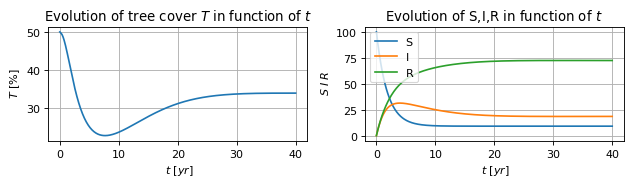

In [9]:
def Q4_plot2():
    T0 = 50
    params = get_default_params()
    Ts   = np.linspace(0,40,500)
    X = human_action_model(Ts,T0,params)
    
    plt.figure(figsize=(8, 4), dpi=80)
    plt.subplot(2,2,1)
    plt.plot(Ts,X[:,0])
    plt.title("Evolution of tree cover $T$ in function of $t$")
    plt.grid()
    plt.ylabel(r' $T \; [\%]$')
    plt.xlabel(r' $t \; [yr]$')
    plt.subplot(2,2,2)
    plt.title("Evolution of S,I,R in function of $t$")
    plt.ylabel(r' $S \; I \; R$')
    plt.xlabel(r' $t \; [yr]$')
    plt.plot(Ts,X[:,1],label='S')
    plt.plot(Ts,X[:,2],label='I')
    plt.plot(Ts,X[:,3],label='R')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.savefig('evolution_TSIR.png')
    plt.show()
    
Q4_plot2()